## Intro

Fashion MNIST is in the same format as MNIST, but more challenging. For example this same program would get around 98% accuracy on standard MNIST, but will get around 88% accuracy on Fashion MNIST.

I did a PR in tinygrad to add this feature here https://github.com/tinygrad/tinygrad/pull/6961 and it got merged.

Outside a notebook, this can be done:
    FASHION=1 python3 ./examples/beautiful_mnist.py

This is similar to my 01 notebook except I added in the colored image at the bottom.

## Dataset

In [1]:
from tinygrad.nn.datasets import mnist
X_train, Y_train, X_test, Y_test = mnist(fashion=1)
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)
# (60000, 1, 28, 28) dtypes.uchar (60000,) dtypes.uchar

(60000, 1, 28, 28) dtypes.uchar (60000,) dtypes.uchar


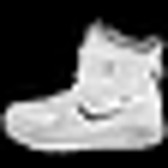

In [2]:
from IPython.display import display
import numpy as np
from PIL import Image

reshaped = X_train[0].reshape(28, 28)
nparray = reshaped.numpy()
nparray = nparray.astype(np.uint8)
img = Image.fromarray(nparray)
img = img.resize((168, 168))

display(img)

## Model

In [3]:
from tinygrad import Tensor, nn

class Model:
  def __init__(self):
    self.l1 = nn.Conv2d(1, 32, kernel_size=(3,3))
    self.l2 = nn.Conv2d(32, 64, kernel_size=(3,3))
    self.l3 = nn.Linear(1600, 10)

  def __call__(self, x:Tensor) -> Tensor:
    x = self.l1(x).relu().max_pool2d((2,2))
    x = self.l2(x).relu().max_pool2d((2,2))
    return self.l3(x.flatten(1).dropout(0.5))

model = Model()

## Train

In [4]:
from tinygrad import TinyJit

optim = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 128

@TinyJit
def step():
  Tensor.training = True  # makes dropout work
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X, Y = X_train[samples], Y_train[samples]
  optim.zero_grad()
  loss = model(X).sparse_categorical_crossentropy(Y).backward()
  optim.step()
  return loss

In [5]:
from tinygrad.helpers import trange

for i in (t:=trange(7000)):
  loss = step()
  if i%100 == 0:
    Tensor.training = False
  if i%10 == 0: acc = (model(X_test).argmax(axis=1) == Y_test).mean().item()
  t.set_description(f"loss: {loss.item():6.2f}     test_accuracy: {acc*100:5.2f}%")
print(f"loss {loss.item():.2f}, acc {acc*100.:.2f}%")

loss:   0.30     test_accuracy: 88.77%: 100%|█| 7000/7000 [01:30<00:00, 77.06it/


loss 0.30, acc 88.77%


## Colored Tiles

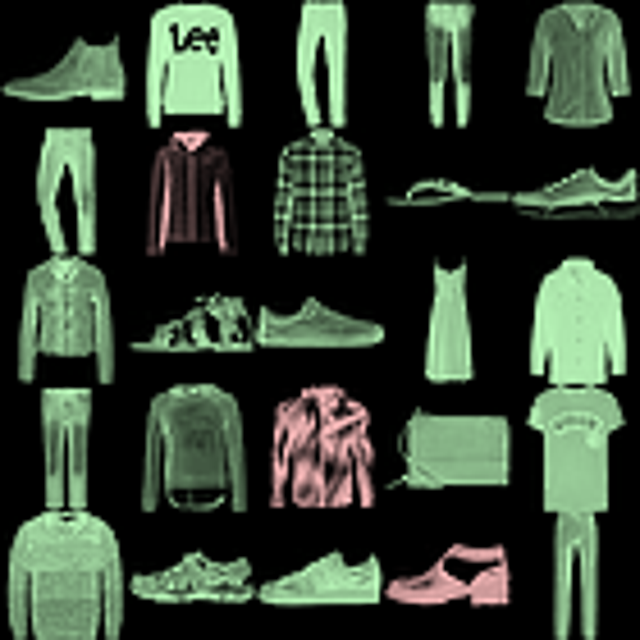

In [6]:
predictions = model(X_test)
grids = 5
image = np.zeros((grids*28, grids*28, 3), np.uint8)

for i in range(grids):
    for j in range(grids):
        idx = i*grids+j
        if predictions.argmax(axis=1)[idx].item() == Y_test[idx].item():
            this_img = np.array([X_test[idx].numpy() * 0.75, X_test[idx].numpy() * 1.0, X_test[idx].numpy() * 0.75])
        else:
            this_img = np.array([X_test[idx].numpy() * 1.0, X_test[idx].numpy() * 0.75, X_test[idx].numpy() * 0.75])
        this_img = this_img.reshape(3, 28, 28)
        this_img = np.transpose(this_img, (1, 2, 0))
        image[i*28:(i+1)*28, j*28:(j+1)*28, :] = this_img

image = Image.fromarray(image)
image = image.resize((640, 640))

display(image)

Correct predictions are green and bad predictions are red.